In [1]:

#!pip install --user scikit-image

In [2]:
%matplotlib notebook
import os
import struct
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td 
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2

import nntools as nt

import Data
import darknet
import yolo2loss as loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
batch_size = 32
meta = defaultdict()
meta['anchors'] = 5
meta['classes'] = 20
meta['batch_size'] = batch_size
meta['threshold'] = 0.6
meta['anchor_bias'] = np.array([1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52])
meta['scale_no_obj'] = 1
meta['scale_coords'] = 1
meta['scale_class'] = 1
meta['scale_obj']  = 5
meta['iteration'] = 0 
#meta['train_samples'] = len(voc_2007) + sum(voc_2012["train"]==1)
#meta['iterations_per_epoch'] = meta['train_samples']/batch_size

In [4]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'
data = Data.getdata(dataset_root_dir)
train_set, test_set = data

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

myimshow(train_set[100]['image'])

<IPython.core.display.Javascript object>

In [6]:
class Yolo_detector(darknet.Yolov2):
    def __init__(self):
        super(Yolo_detector, self).__init__()
        
    def criterion(self, y, d):
        return loss.Yolov2Loss(y, d[0], d[1])

In [7]:
net = Yolo_detector()
net = darknet.load_pretrained_weights(net)

# childs = list(net.children())
# for i in range(len(childs)):
#     for param in childs[i].parameters():
#         if i < 38:
#             param.requires_grad = False
#         else:
#             param.requires_grad = True
            
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv19.weight torch.Size([1024, 1024, 3, 3]) True
bn19.weight torch.Size([1024]) True
bn19.bias torch.Size([1024]) True
conv20.weight torch.Size([1024, 1024, 3, 3]) True
bn20.weight torch.Size([1024]) True
bn20.bias torch.Size([1024]) True
conv21.weight torch.Size([1024, 3072, 3, 3]) True
bn21.weight torch.Size([1024]) True
bn21.bias torch.Size([1024]) True
conv22.weight torch.Size([125, 1024, 1, 1]) True
conv22.bias torch.Size([125]) True


In [8]:
class YOLOStatsManager(nt.StatsManager):
    def __init__(self):
        super(YOLOStatsManager, self).__init__()

    def init(self):
        super(YOLOStatsManager, self).init()
        #self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d): 
        super(YOLOStatsManager, self).accumulate(loss, x, y, d)
#         _, l = torch.max(y, 1)
#         self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(YOLOStatsManager, self).summarize() 
#         accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss}

In [9]:
!rm -r yolo_voc1

lr = 1e-3
net = Yolo_detector()
net = darknet.load_pretrained_weights(net)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = YOLOStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, output_dir="yolo_voc1", perform_validation_during_training=False)

In [10]:
aa = td.DataLoader(train_set, batch_size=4, shuffle=True,
                                     drop_last=True, pin_memory=True)
# for i in aa:
#     x, b, n = i['image'].cuda(), i['bboxes'].cuda(), i['n_true'].cuda()
#     print(b.shape)

<IPython.core.display.Javascript object>


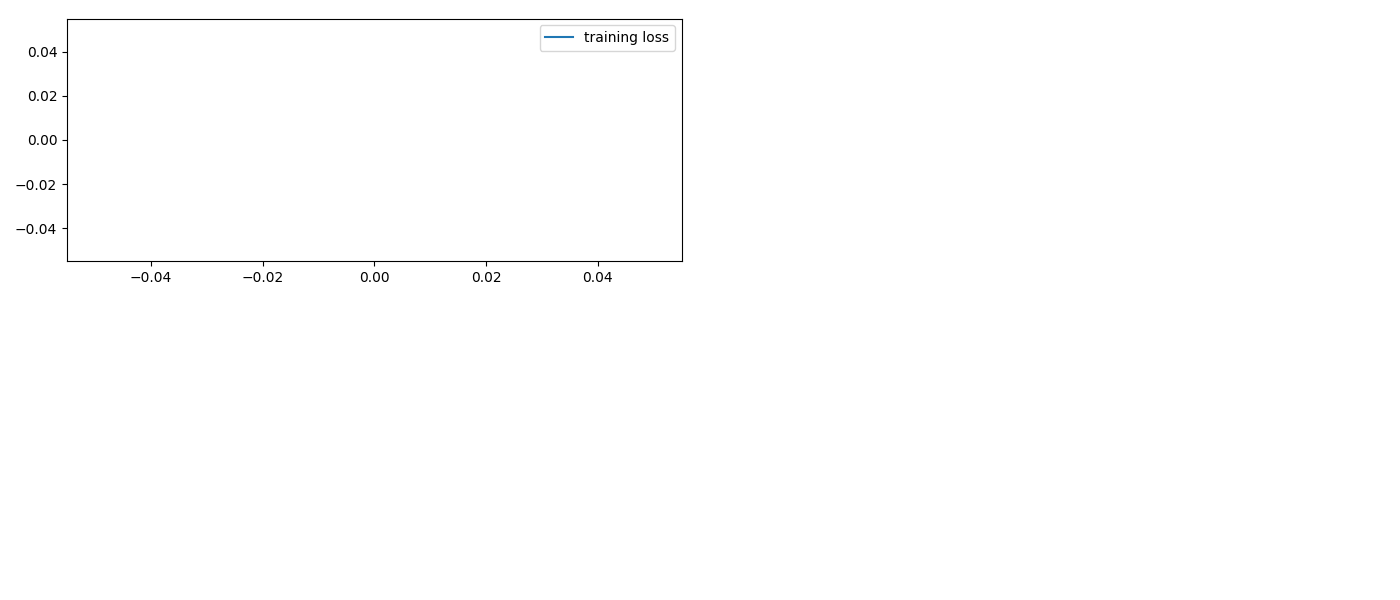

Start/Continue training from epoch 0


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 1 and 2 at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/THC/generic/THCTensorMath.cu:74

In [11]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k]['loss'] for k in range(exp.epoch)], label="training loss")
    plt.tight_layout()
    fig.canvas.draw()
    axes.legend()

fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))